# Adatforrás:
https://www.kaggle.com/datasets/rajattomar132/payment-date-dataset?select=dataset.csv

## adatforrás leírása
The invoices dataset contains the past payment information and behaviour of various buyers. Based on the previous payment patterns, the ML model will predict what will be the date a payment is made by the customer for an invoice.
The model will also predict which aging bucket the invoice falls into based on the predicted payment date.

# Feladat
A számlák adatai alapján prediktálni azok várható kifizetési dátumát

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('data/payment_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  int64  
 5   doc_id                  50000 non-null  int64  
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  int64  
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  int64  
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

In [5]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,200769623,WAL-MAR corp,2/11/2020 0:00,2020,1930438491,1/26/2020,20200125,20200126,20200210,USD,RV,1,NaN,54273.28,20200126,NAH4,1.930438e+09,0
1,U001,200980828,BEN E,8/8/2019 0:00,2019,1929646410,7/22/2019,20190722,20190722,20190811,USD,RV,1,NaN,79656.60,20190722,NAD1,1.929646e+09,0
2,U001,200792734,MDV/ trust,12/30/2019 0:00,2019,1929873765,9/14/2019,20190914,20190914,20190929,USD,RV,1,NaN,2253.86,20190914,NAA8,1.929874e+09,0
3,CA02,140105686,SYSC llc,NaN,2020,2960623488,3/30/2020,20200330,20200330,20200410,CAD,RV,1,NaN,3299.70,20200331,CA10,2.960623e+09,1
4,U001,200769623,WAL-MAR foundation,11/25/2019 0:00,2019,1930147974,11/13/2019,20191113,20191113,20191128,USD,RV,1,NaN,33133.29,20191113,NAH4,1.930148e+09,0


In [6]:
#látom hogy 50.000 sor van, van olyan oszlop amiben nincs adat, és van olyan amiben 10.000 és 6db null van

nan_columns = df.columns[df.isnull().any()].tolist()
df[nan_columns].isnull().sum()

clear_date       10000
area_business    50000
invoice_id           6
dtype: int64

In [7]:
# ha nem dátum lenne, akkor a clear_date oszlopot meg lehet próbálni majd a nullokat átlag számokkal helyettesíteni
# de mivel dátum, és relatív érték, így nincs átlaga

# ezért eltávolítom azokat a sorokat, ahol NaN érték van ebben a 2 oszlopban
df = df.dropna(subset=['clear_date'])
df = df.dropna(subset=['invoice_id'])

# a komplett oszlopot is eldobom, amiben csak nan van
df=df.drop('area_business', axis=1)

In [8]:
#már nincs null

nan_columns = df.columns[df.isnull().any()].tolist()
df[nan_columns].isnull().sum() 

Series([], dtype: float64)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39994 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           39994 non-null  object 
 1   cust_number             39994 non-null  object 
 2   name_customer           39994 non-null  object 
 3   clear_date              39994 non-null  object 
 4   buisness_year           39994 non-null  int64  
 5   doc_id                  39994 non-null  int64  
 6   posting_date            39994 non-null  object 
 7   document_create_date    39994 non-null  int64  
 8   document_create_date.1  39994 non-null  int64  
 9   due_in_date             39994 non-null  int64  
 10  invoice_currency        39994 non-null  object 
 11  document type           39994 non-null  object 
 12  posting_id              39994 non-null  int64  
 13  total_open_amount       39994 non-null  float64
 14  baseline_create_date    39994 non-null  int

In [10]:
#oszlopok eldobása amik sztem nem relevánsak
df=df.drop('document_create_date.1', axis=1)
df=df.drop('document_create_date', axis=1)
df=df.drop('baseline_create_date', axis=1)

df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,cust_payment_terms,invoice_id,isOpen
0,U001,200769623,WAL-MAR corp,2/11/2020 0:00,2020,1930438491,1/26/2020,20200210,USD,RV,1,54273.28,NAH4,1.930438e+09,0
1,U001,200980828,BEN E,8/8/2019 0:00,2019,1929646410,7/22/2019,20190811,USD,RV,1,79656.60,NAD1,1.929646e+09,0
2,U001,200792734,MDV/ trust,12/30/2019 0:00,2019,1929873765,9/14/2019,20190929,USD,RV,1,2253.86,NAA8,1.929874e+09,0
4,U001,200769623,WAL-MAR foundation,11/25/2019 0:00,2019,1930147974,11/13/2019,20191128,USD,RV,1,33133.29,NAH4,1.930148e+09,0
5,CA02,140106181,THE corporation,12/4/2019 0:00,2019,2960581231,9/20/2019,20191004,CAD,RV,1,22225.84,CA10,2.960581e+09,0


In [11]:
#duplikáció gyors vizsgálat

#van duplikáció számlaszám alapján, ami egyedi külcs kellene legyen, tovább vizsgálom, hogy minden más adatuk is egyezik-e
has_duplicates = df['invoice_id'].duplicated().any()
print("Tartalmaz duplikációkat:", has_duplicates)

Tartalmaz duplikációkat: True


In [12]:
#duplikációk ellenőrzése

#azonosítani kell a duplikált számlaszámokat
duplicated = df[df.duplicated('invoice_id', keep=False)]

#csoportosítom számlaszám szerint, és ellenőrzöm, hogy a többi oszlop értékei azonosak-e
check = duplicated.groupby('invoice_id').apply(lambda x: x.nunique() == 1)

#azokat a számlaszámokat szűröm ki, ahol a többi oszlop értékei is azonosak
same_values = check.all(axis=1)

#az azonos értékeket tartalmazó számlaszámok megjelenítése
duplicated_same = duplicated[duplicated['invoice_id'].isin(same_values[same_values].index)]

#rendezés számlaszám alapján
duplicated_same_ordered = duplicated_same.sort_values(by='invoice_id')

#eredmény megjelenítése
print(duplicated_same_ordered)

      business_code cust_number     name_customer      clear_date  \
7057           U001   200794332   COST foundation  1/14/2019 0:00   
37468          U001   200794332   COST foundation  1/14/2019 0:00   
45187          U001   200769623   WAL-MAR systems  1/14/2019 0:00   
49361          U001   200769623   WAL-MAR systems  1/14/2019 0:00   
46651          U001   200769623        WAL-MAR in  1/14/2019 0:00   
...             ...         ...               ...             ...   
23212          CA02   140106181   THE  foundation   4/8/2020 0:00   
45534          CA02   140106181  THE  corporation  4/24/2020 0:00   
48743          CA02   140106181  THE  corporation  4/24/2020 0:00   
35761          CA02   140105686  SYSC corporation  3/12/2020 0:00   
40454          CA02   140105686  SYSC corporation  3/12/2020 0:00   

       buisness_year      doc_id posting_date  due_in_date invoice_currency  \
7057            2019  1928543057   12/31/2018     20190115              USD   
37468        

In [13]:
# Duplikált sorok törlése az összes oszlop alapján, csak az első megtartása, és az eredeti DataFrame frissítése
df.drop_duplicates(keep='first', inplace=True)

In [14]:
#vissza ellenőrzés, marad-e duplikációú

has_duplicates = df['invoice_id'].duplicated().any()
print("Tartalmaz duplikációkat:", has_duplicates)

Tartalmaz duplikációkat: False


In [15]:
#dátum oszlopok ellenőrzése
print(df[['due_in_date', 'clear_date', 'posting_date']])

#látszik hogy 3 féleképpen vannak tárolva

       due_in_date       clear_date posting_date
0         20200210   2/11/2020 0:00    1/26/2020
1         20190811    8/8/2019 0:00    7/22/2019
2         20190929  12/30/2019 0:00    9/14/2019
4         20191128  11/25/2019 0:00   11/13/2019
5         20191004   12/4/2019 0:00    9/20/2019
...            ...              ...          ...
49994     20190725   7/25/2019 0:00    7/10/2019
49996     20190830    9/3/2019 0:00    8/15/2019
49997     20200305    3/5/2020 0:00    2/19/2020
49998     20191212  12/12/2019 0:00   11/27/2019
49999     20190124   1/15/2019 0:00     1/5/2019

[39152 rows x 3 columns]


In [16]:
# a due_in_date számként van tárolva, ezt átalakítom, mert fontos adat
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')

In [17]:
print(df[['due_in_date', 'clear_date', 'posting_date']])

      due_in_date       clear_date posting_date
0      2020-02-10   2/11/2020 0:00    1/26/2020
1      2019-08-11    8/8/2019 0:00    7/22/2019
2      2019-09-29  12/30/2019 0:00    9/14/2019
4      2019-11-28  11/25/2019 0:00   11/13/2019
5      2019-10-04   12/4/2019 0:00    9/20/2019
...           ...              ...          ...
49994  2019-07-25   7/25/2019 0:00    7/10/2019
49996  2019-08-30    9/3/2019 0:00    8/15/2019
49997  2020-03-05    3/5/2020 0:00    2/19/2020
49998  2019-12-12  12/12/2019 0:00   11/27/2019
49999  2019-01-24   1/15/2019 0:00     1/5/2019

[39152 rows x 3 columns]


In [18]:
# Dátumok konvertálása datetime formátumba, egységesen, mert 3 féle képpen vannak tárolva még
df['clear_date'] = pd.to_datetime(df['clear_date'])
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['due_in_date'] = pd.to_datetime(df['due_in_date'])

In [19]:
#innentől egységesek a dátumok
print(df[['due_in_date', 'clear_date', 'posting_date']])

      due_in_date clear_date posting_date
0      2020-02-10 2020-02-11   2020-01-26
1      2019-08-11 2019-08-08   2019-07-22
2      2019-09-29 2019-12-30   2019-09-14
4      2019-11-28 2019-11-25   2019-11-13
5      2019-10-04 2019-12-04   2019-09-20
...           ...        ...          ...
49994  2019-07-25 2019-07-25   2019-07-10
49996  2019-08-30 2019-09-03   2019-08-15
49997  2020-03-05 2020-03-05   2020-02-19
49998  2019-12-12 2019-12-12   2019-11-27
49999  2019-01-24 2019-01-15   2019-01-05

[39152 rows x 3 columns]


In [20]:
df.head() # egységesek a dátumok, nincs nan sehol, irreleváns oszlopok törölve, duplikációk törölve

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,cust_payment_terms,invoice_id,isOpen
0,U001,200769623,WAL-MAR corp,2020-02-11,2020,1930438491,2020-01-26,2020-02-10,USD,RV,1,54273.28,NAH4,1.930438e+09,0
1,U001,200980828,BEN E,2019-08-08,2019,1929646410,2019-07-22,2019-08-11,USD,RV,1,79656.60,NAD1,1.929646e+09,0
2,U001,200792734,MDV/ trust,2019-12-30,2019,1929873765,2019-09-14,2019-09-29,USD,RV,1,2253.86,NAA8,1.929874e+09,0
4,U001,200769623,WAL-MAR foundation,2019-11-25,2019,1930147974,2019-11-13,2019-11-28,USD,RV,1,33133.29,NAH4,1.930148e+09,0
5,CA02,140106181,THE corporation,2019-12-04,2019,2960581231,2019-09-20,2019-10-04,CAD,RV,1,22225.84,CA10,2.960581e+09,0


In [21]:
#feature engineering
# kifizetési napok kiszámítása 2 bázis értékhez viszonyítva is
# ezzel alőáll 2 target oszlop is, megnézem melyik lenne a jobb
df['payment_delay_from_posting'] = (df['clear_date'] - df['posting_date']).dt.days
df['payment_delay_from_due'] = (df['clear_date'] - df['due_in_date']).dt.days

In [22]:
print(df[['payment_delay_from_posting', 'payment_delay_from_due']])

       payment_delay_from_posting  payment_delay_from_due
0                              16                       1
1                              17                      -3
2                             107                      92
4                              12                      -3
5                              75                      61
...                           ...                     ...
49994                          15                       0
49996                          19                       4
49997                          15                       0
49998                          15                       0
49999                          10                      -9

[39152 rows x 2 columns]


In [23]:
#dátum mezők eldobása, már nem kell, ez nem idősor lesz
df = df.drop('clear_date', axis=1)
df = df.drop('posting_date', axis=1)
df = df.drop('due_in_date', axis=1)

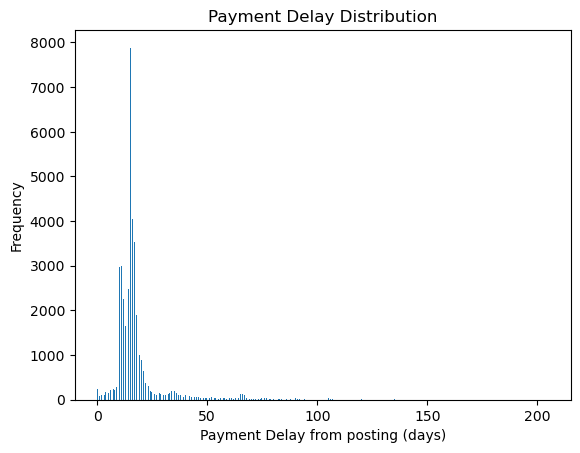

In [24]:
# target adatok megértése

# Késleltetés eloszlása - a feladás napjához képesti kifizetési napok
plt.hist(df['payment_delay_from_posting'], bins=500)
plt.xlabel('Payment Delay from posting (days)')
plt.ylabel('Frequency')
plt.title('Payment Delay Distribution')
plt.show()

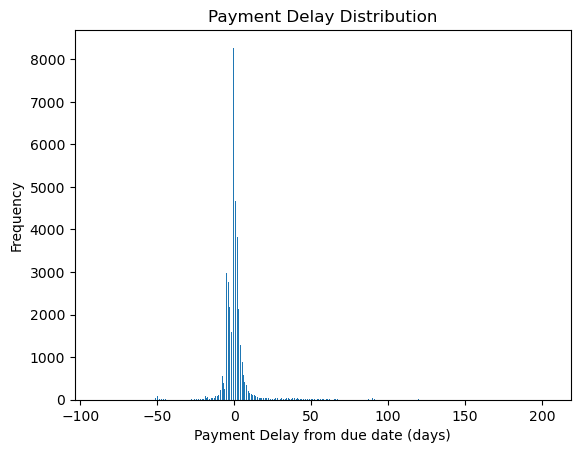

In [25]:
# Késleltetés eloszlása - a fizetési határidő napjához képesti kifizetési napok
plt.hist(df['payment_delay_from_due'], bins=500)
plt.xlabel('Payment Delay from due date (days)')
plt.ylabel('Frequency')
plt.title('Payment Delay Distribution')
plt.show()

In [26]:
# 2 targetem is van, lehet próbálkozni hogy melyik ad jobb eredményt (a due)
target_feature = 'payment_delay_from_due'
#target_feature = 'payment_delay_from_posting'

#a másik targetet eldobom, mert nagyon hasonlít a megmaradó targetre
#df=df.drop('payment_delay_from_due', axis=1)
df=df.drop('payment_delay_from_posting', axis=1)

In [27]:
#cust_number-ben számokat várok, de vannak benne szöveges értékek is, amiket kezelni akarok majd
df_wrong_cust_number = df[~df['cust_number'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
print(df_wrong_cust_number[['cust_number']])

      cust_number
34         CCCA02
44         CCU001
144        CCCA02
186        CC6050
202        CC6050
...           ...
49866      CCU013
49888      CCCA02
49895      CCCA02
49923      CCU013
49961      CCCA02

[1265 rows x 1 columns]


In [28]:
#szöveges tartalmak számmá alakítása label encodinggal
from sklearn.preprocessing import LabelEncoder

# LabelEncoder betöltése
label_encoder = LabelEncoder()

# átalakítás
df['business_code_encoded'] = label_encoder.fit_transform(df['business_code'])
df['name_customer_encoded'] = label_encoder.fit_transform(df['name_customer']) #ez lehet nem is kellene, az id-ja megvan amúgy is
df['invoice_currency_encoded'] = label_encoder.fit_transform(df['invoice_currency'])
df['document_type_encoded'] = label_encoder.fit_transform(df['document type'])
df['cust_payment_terms_encoded'] = label_encoder.fit_transform(df['cust_payment_terms'])
df['cust_number_encoded'] = label_encoder.fit_transform(df['cust_number']) #van benne szöveges azonosító is, bár nem látszik elsőre

print(df[['business_code','name_customer','invoice_currency','document type','cust_payment_terms','cust_number']])
print(df[['business_code_encoded','name_customer_encoded','invoice_currency_encoded','document_type_encoded','cust_payment_terms_encoded','cust_number_encoded']])


      business_code       name_customer invoice_currency document type  \
0              U001        WAL-MAR corp              USD            RV   
1              U001              BEN E               USD            RV   
2              U001          MDV/ trust              USD            RV   
4              U001  WAL-MAR foundation              USD            RV   
5              CA02    THE  corporation              CAD            RV   
...             ...                 ...              ...           ...   
49994          U001        C&S WH trust              USD            RV   
49996          U001          WAL-MAR co              USD            RV   
49997          U001    SAFEW associates              USD            RV   
49998          U001           BJ'S  llc              USD            RV   
49999          U001            DEC corp              USD            RV   

      cust_payment_terms cust_number  
0                   NAH4   200769623  
1                   NAD1   200980

In [29]:
# régiek eldobása
df = df.drop('business_code', axis=1)
df = df.drop('name_customer', axis=1)
df = df.drop('invoice_currency', axis=1)
df = df.drop('document type', axis=1)
df = df.drop('cust_payment_terms', axis=1)
df = df.drop('cust_number', axis=1)

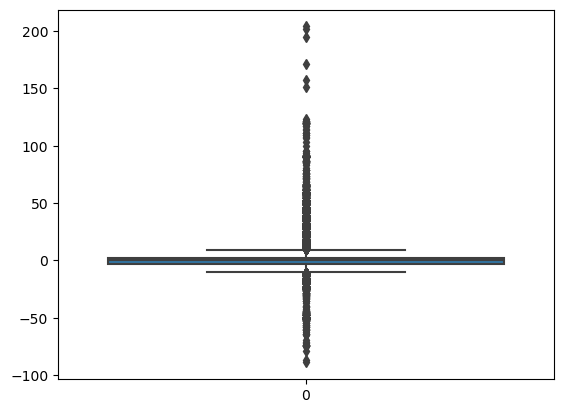

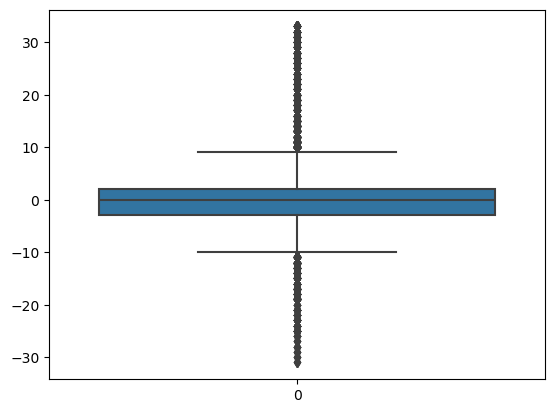

In [30]:
#outlayerek kezelése

from scipy import stats
import seaborn as sns

# Vizualizáljuk az outliereket
sns.boxplot(data=df[target_feature])
plt.show()

# Azonosítsuk az outliereket
z_scores = np.abs(stats.zscore(df[[target_feature]]))
#z_scores = pd.DataFrame(stats.zscore(df[[target_feature]]))

# NumPy tömbbé alakítás
z_scores_np = z_scores.to_numpy()

outliers_z = (z_scores_np > 3).flatten()  #max 3-at javasolnak

# outlierek megtisztítása
df_clean = df[~outliers_z]

# Vizualizáljuk a tisztított adatokat
sns.boxplot(data=df_clean[target_feature])
plt.show()

In [31]:
print(type(z_scores))
print(type(z_scores_np))

print(len(z_scores_np))

print(len(outliers_z))
print(len(df))
print(z_scores_np.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
39152
39152
39152
(39152, 1)


In [32]:
# skálázom a megmaradt targetet MinMaxScaler-er -> eltolom 0.1-től az adatokat pozitívba hogy ne legyen benne nulla
from sklearn.preprocessing import MinMaxScaler

#outlayer nélküli adathalmazt használok már
y_orig = df_clean[target_feature].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(.01, 1)) # a 0.01 a MAPE miatt van, mert nem maradhat benne nulla

df_scaled = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

In [33]:
# X y előállítása
y = df_scaled[[target_feature]]
X = df_scaled.drop(columns=target_feature)

#1 dimenzióssá alakítom, már nem volt több dimenziós így sem, csak a formátum változik
y = np.ravel(y)

#X = pd.get_dummies(X, columns=['business_code']) #one hot encoding, de inkább label encoding lesz

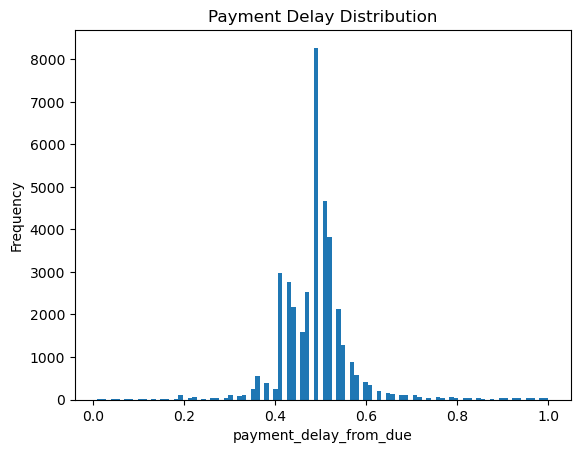

In [34]:
# Késleltetés eloszlása a standardizálás vagy skálzás után
plt.hist(y, bins=100)
plt.xlabel(target_feature)
plt.ylabel('Frequency')
plt.title('Payment Delay Distribution')
plt.show()

In [35]:
#felosztom az adathalmazt trainra, VALIDÁCIÓRA (cv) és teszt-re
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print('X',len(X))
print('X_train',len(X_train))
print('X_test',len(X_test))
print('X_cv',len(X_cv))

X 38131
X_train 22878
X_test 7627
X_cv 7626


In [36]:
#index reset biztos ami biztos
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

mae_train: 0.022442470466566212
mae_test: 0.031918669291812356
mean test: 0.4910341140028845
mae_cv: 0.032636005443566596
mean cv: 0.4902635105232101
MAPE: 5.170829087668727
MAPE: 6.955610949260612
MAPE: 7.355605371158962


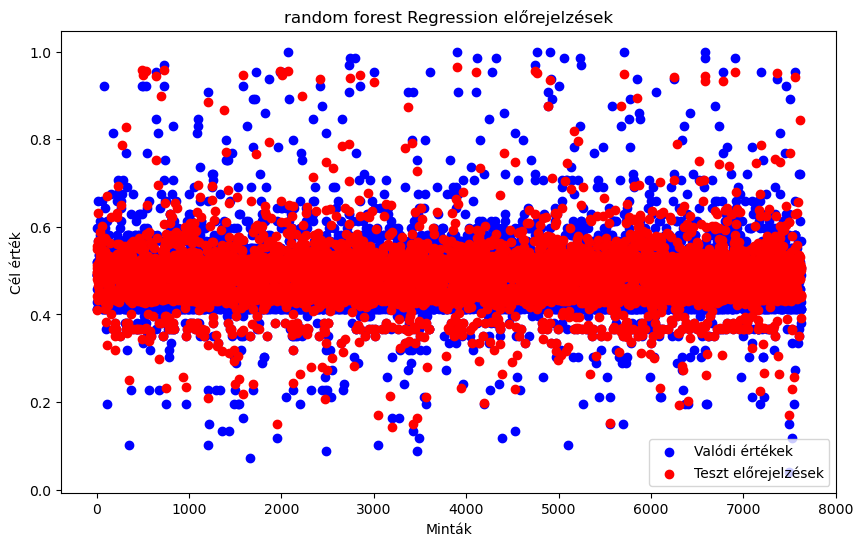

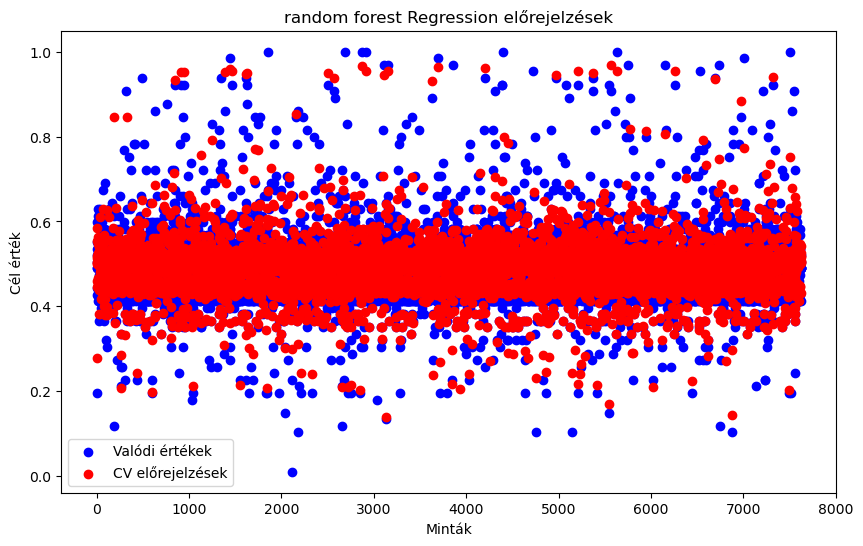

In [37]:
#random forest

from sklearn.ensemble import RandomForestRegressor 

#Legjobb hiperparaméterek: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
#Legjobb hiperparaméterek: {'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 120}
regr = RandomForestRegressor(bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=120,  random_state=42)
regr.fit(X_train, y_train)

y_pred_train = regr.predict(X_train)
y_pred_test = regr.predict(X_test)
y_pred_cv = regr.predict(X_cv)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_cv = mean_absolute_error(y_cv, y_pred_cv)

print(f'mae_train: {mae_train}')
print(f'mae_test: {mae_test}')
print(f'mean test: {np.mean(y_test)}')
print(f'mae_cv: {mae_cv}')
print(f'mean cv: {np.mean(y_cv)}')

#numpy MAPE számítás
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
mape_cv = mean_absolute_percentage_error(y_cv, y_pred_cv)*100

print(f'MAPE: {mape_train}')
print(f'MAPE: {mape_test}')
print(f'MAPE: {mape_cv}')


# Előrejelzések megjelenítése - teszt
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_test)), y_pred_test, color='red', label='Teszt előrejelzések')
plt.title('random forest Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

# Előrejelzések megjelenítése - cv
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_cv)), y_cv, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_cv)), y_pred_cv, color='red', label='CV előrejelzések')
plt.title('random forest Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_test)
print(r2)

0.5435317699586639


4.279366947796377
7.263859493186285
7.7557200272426154


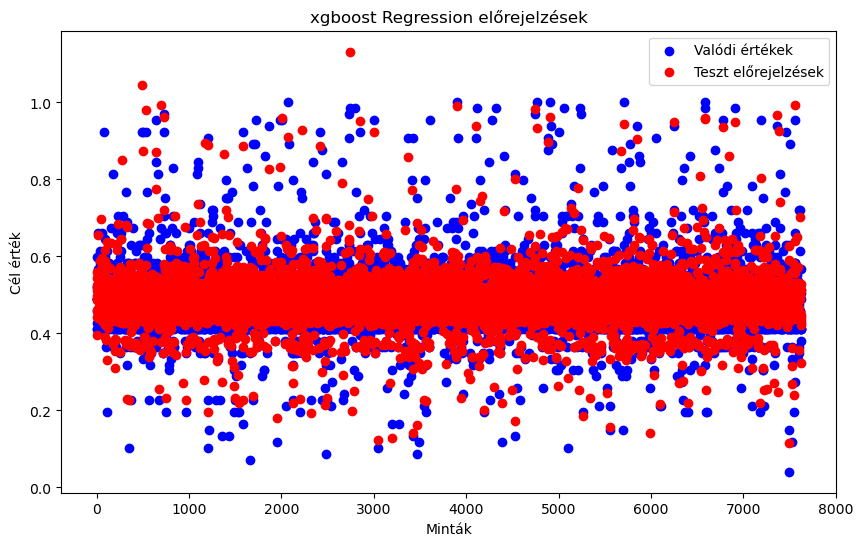

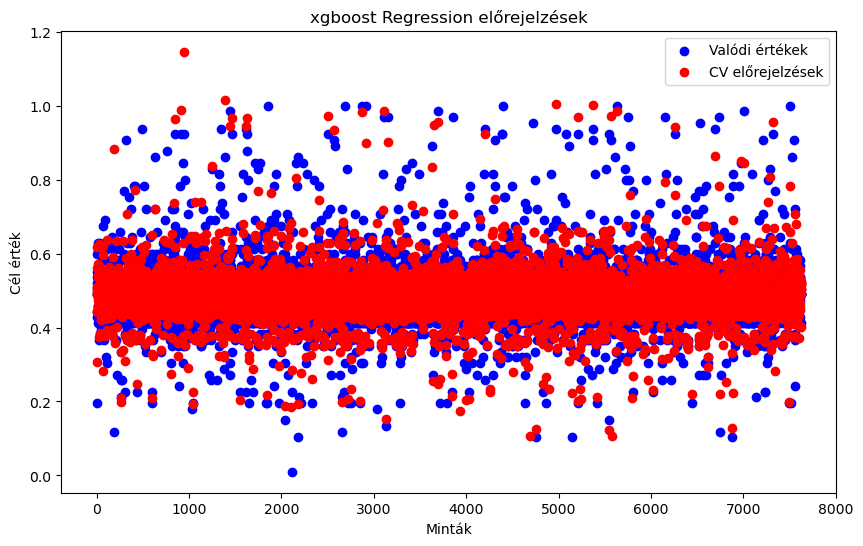

In [39]:
#xgboost kézi próbálgatás, majd a jónak tűnő értékek átvezetése a grid search-be, és onnan ide vissza a legjobb paraméterek

import xgboost as xgb

# a grid search alapján a legjobb hiperparaméterek: 
#{'colsample_bytree': 1.0, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 130, 'subsample': 1.0}
model = xgb.XGBRegressor(objective='reg:gamma', # a reg:gamma adta a legjobb CV értéket
                         n_estimators=180, 
                         max_depth=8,
                         learning_rate=0.2,
                         subsample=1.0,
                         colsample_bytree=1.0,
                         random_state=42) 

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_cv = model.predict(X_cv)

#mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
#mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
mape_cv = mean_absolute_percentage_error(y_cv, y_pred_cv)*100

print(mape_train) 
print(mape_test)
print(mape_cv)

# Előrejelzések megjelenítése - teszt
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_test)), y_pred_test, color='red', label='Teszt előrejelzések')
plt.title('xgboost Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

# Előrejelzések megjelenítése - cv
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_cv)), y_cv, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_cv)), y_pred_cv, color='red', label='CV előrejelzések')
plt.title('xgboost Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

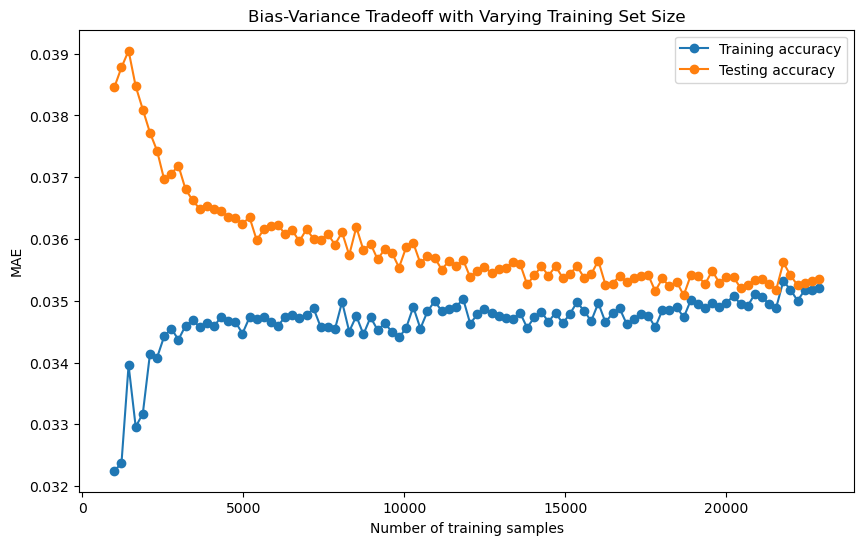

In [40]:
#Bias-Variance ábra

from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

train_count = len(X_train) #itt adom meg hány db adaton tanítom be, a maximum: len(X_train)
train_sizes = np.linspace(start=1000, stop=train_count, num=100, dtype=int) 

train_scores = []
test_scores = []

# Modellek illesztése különböző tanító adatok számával
for train_size in train_sizes:
    X_train_t = X_train[:train_size]
    y_train_t = y_train[:train_size]
    
    regr = xgb.XGBRegressor(objective='reg:gamma', # a reg:gamma adta a legjobb CV értéket
                         n_estimators=180, 
                         max_depth=8,
                         learning_rate=0.2,
                         subsample=1.0,
                         colsample_bytree=1.0,
                         random_state=42) 

    #nem ezek a paraméterek hozzák a legjobb eredményt!!!! de ez gyorsabban lefut
    regr = RandomForestRegressor(bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=20, random_state=42)

    regr = CatBoostRegressor(iterations=50,learning_rate=0.05,depth=10,loss_function='MAPE',verbose=False)

    regr.fit(X_train_t, y_train_t)
    y_pred_train = regr.predict(X_train_t)
    y_pred_test = regr.predict(X_test)

    #MAE
    score_train = mean_absolute_error(y_train_t, y_pred_train)
    score_test = mean_absolute_error(y_test, y_pred_test)

    #MAPE
    #score_train = np.mean(np.abs((y_train_t - y_pred_train) / y_train_t)) * 100
    #score_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
        
    train_scores.append(score_train)
    test_scores.append(score_test)

#pontosság ábrázolása
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label='Training accuracy', marker='o')
plt.plot(train_sizes, test_scores, label='Testing accuracy', marker='o')
plt.xlabel('Number of training samples')
plt.ylabel('MAE')
plt.title('Bias-Variance Tradeoff with Varying Training Set Size')
plt.legend()
plt.show()

0:	learn: 0.0489736	total: 9.72ms	remaining: 29.2s
1000:	learn: 0.0257541	total: 9.77s	remaining: 19.5s
2000:	learn: 0.0229296	total: 18.9s	remaining: 9.42s
2999:	learn: 0.0213127	total: 29.1s	remaining: 0us
4.61127979092252
6.661803067045814
7.066731092403367


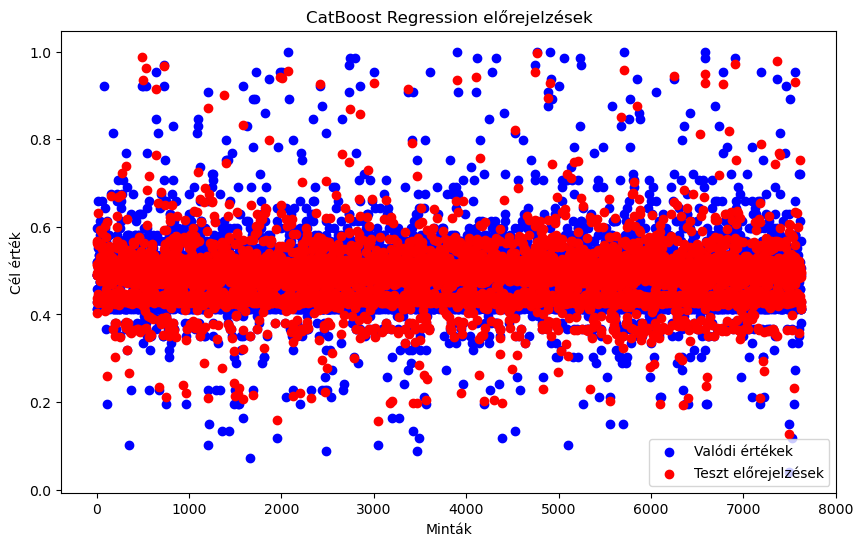

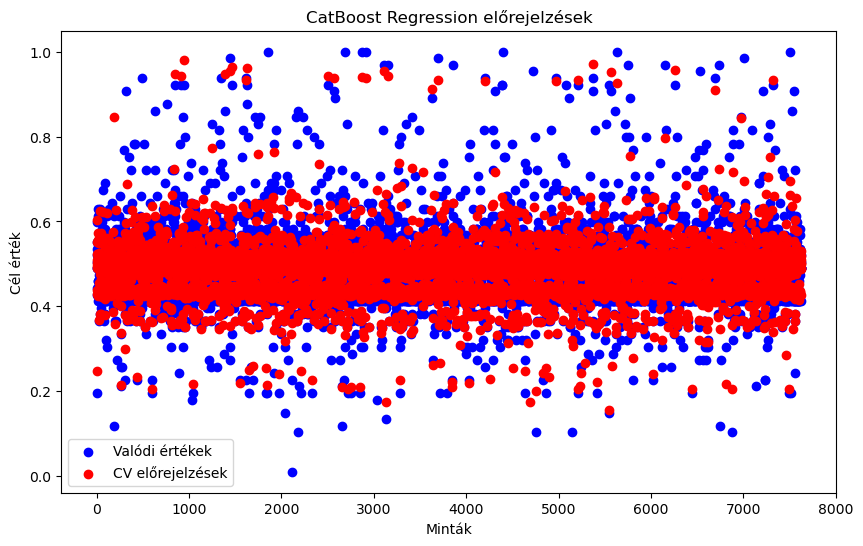

In [41]:
#catboost, a legjobb paraméterek alkalmazása és ábrázolása
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=3000,
                          learning_rate=0.05,
                          depth=10,
                          loss_function='MAPE',
                          verbose=1000)

# Modell betanítása
model.fit(X_train, y_train, cat_features=None)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_cv = model.predict(X_cv)

#mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
#mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
mape_cv = mean_absolute_percentage_error(y_cv, y_pred_cv)*100

print(mape_train) 
print(mape_test)
print(mape_cv)

# Előrejelzések megjelenítése - teszt
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_test)), y_pred_test, color='red', label='Teszt előrejelzések')
plt.title('CatBoost Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

# Előrejelzések megjelenítése - cv
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_cv)), y_cv, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_cv)), y_pred_cv, color='red', label='CV előrejelzések')
plt.title('CatBoost Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

#az eddigi legjobb MAPE due_date targetre
#due_date - az első outlayer képzéssel   = 0.571013984655471,  1.533001086278606,  1.6872489670462736
#due_date - a második outlayer képzéssel = 1.4520645562027292, 1.5258463465165917, 1.6076007554767875

0.10755944560831684
0.09870664771566962


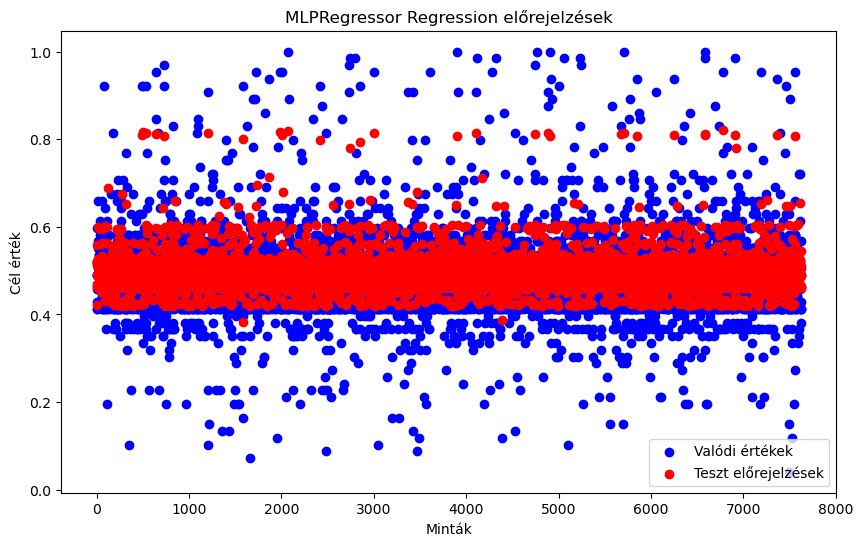

In [42]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train))
#mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test))

mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(mape_train) 
print(mape_test)

# Előrejelzések megjelenítése - teszt
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_test)), y_pred_test, color='red', label='Teszt előrejelzések')
plt.title('MLPRegressor Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

#ez értelmezhetlen MAPE, nagyon rossz a grafikon is ezt mutatja

In [43]:
#TensorFlow Decision Forests
import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf

# TensorFlow DataFrame-ek létrehozása
dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))

# Split the dataset into training and test sets
train_size = int(len(df) * 0.8)
train_dataset = dataset.take(train_size).batch(100)
test_dataset = dataset.skip(train_size).batch(100)

# Létrehozunk egy RandomForest regressziós modellt
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# Tanítjuk a modellt
model.fit(train_dataset)

# Előrejelzések készítése a teszt adatokra
predictions = model.predict(test_dataset)

# Kiértékeljük a modellt
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = np.array(predictions).squeeze()

# Mean Squared Error (MSE) kiszámítása
mse = np.mean((test_labels - predictions)**2)
print(f'MSE: {mse}')

# Mean Absolute Percentage Error (MAPE) kiszámítása
mape = np.mean(np.abs((test_labels - predictions) / test_labels)) * 100
print(f'MAPE: {mape}')

Use /var/folders/d9/k78qy5cx68q0350x4nxbdymm0000gn/T/tmp2xoe_h5f as temporary training directory
Reading training dataset...


2024-08-11 10:16:16.968366: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-11 10:16:16.968392: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-11 10:16:16.968398: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-11 10:16:16.968723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-11 10:16:16.968740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-11 10:16:19.541363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:02.763164. Found 31321 examples.
Training model...


[INFO 24-08-11 10:16:26.8119 CEST kernel.cc:1233] Loading model from path /var/folders/d9/k78qy5cx68q0350x4nxbdymm0000gn/T/tmp2xoe_h5f/model/ with prefix 8671d818d8424640


Model trained in 0:00:08.342697
Compiling model...


[INFO 24-08-11 10:16:28.1744 CEST decision_forest.cc:734] Model loaded with 300 root(s), 654214 node(s), and 9 input feature(s).
[INFO 24-08-11 10:16:28.1745 CEST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-11 10:16:28.1745 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
69/69 [==============================] - 1s 7ms/step
MSE: 0.0030447071601591605
MAPE: 8.524776823832461


2024-08-11 10:16:32.012681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12.895793291082121
12.14330300271126
12.7084368673003
Mean Squared Error: 0.005609470366017836


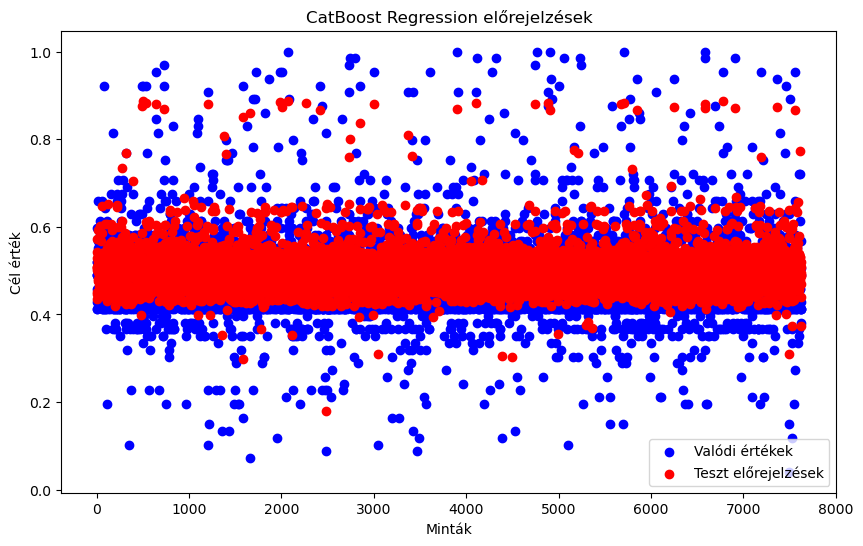

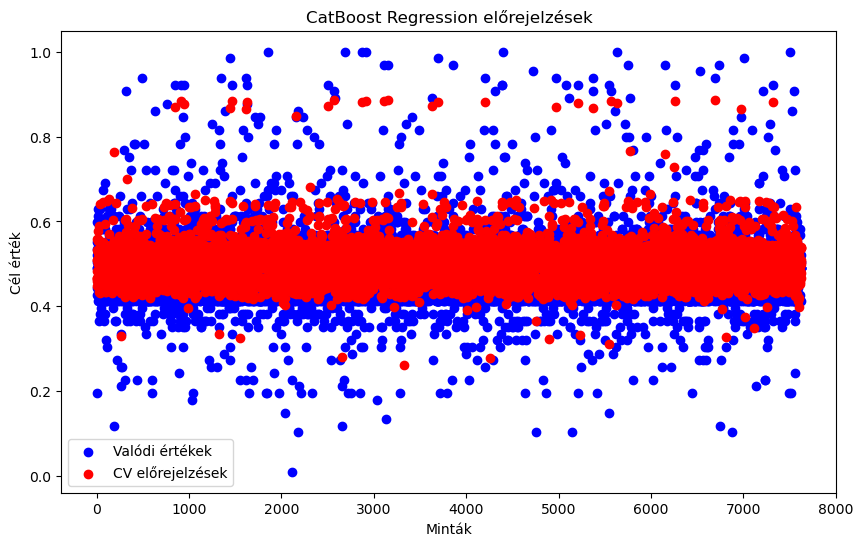

In [45]:
#Support Vector Regression (SVR)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# SVR modell létrehozása és tanítása
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train, y_train)

# Előrejelzések készítése a teszt adatokra
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)
y_pred_cv = svr.predict(X_cv)

mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
mape_cv = mean_absolute_percentage_error(y_cv, y_pred_cv)*100

print(mape_train) 
print(mape_test)
print(mape_cv)

# Kiértékeljük a modellt
mse = mean_squared_error(y_test, y_pred_test)
print(f'Mean Squared Error: {mse}')

# Előrejelzések megjelenítése - teszt
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_test)), y_pred_test, color='red', label='Teszt előrejelzések')
plt.title('CatBoost Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()

# Előrejelzések megjelenítése - cv
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_cv)), y_cv, color='blue', label='Valódi értékek')
plt.scatter(range(len(y_cv)), y_pred_cv, color='red', label='CV előrejelzések')
plt.title('CatBoost Regression előrejelzések')
plt.xlabel('Minták')
plt.ylabel('Cél érték')
plt.legend()
plt.show()


In [46]:
# elvileg megvan a kiválasztott modell, megnézem hogy a k-fold javít-e a mape-n
# illetve hogy milyen különbségek vannak a különböző train halmazokkal

# K-Fold Cross Validáció

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Define the KFold cross-validator
kf = KFold(n_splits=5)

# Initialize the list to store the accuracy for each fold
accuracies = []

# Iterate over each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    regr = RandomForestRegressor(bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=120,  random_state=42)
    regr.fit(X_train, y_train)
    
    # Make predictions on the test set
    #y_pred_train = regr.predict(X_train)
    y_pred_test = regr.predict(X_test)

    # Calculate the accuracy of the predictions
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100

    # Append the accuracy to the list
    accuracies.append(mape_test)

# Calculate and print the average accuracy
average_accuracy = np.mean(accuracies)
print(f"The average accuracy from the 5-fold cross-validation is {average_accuracy}")

# az átlag eredmény rosszabb, a nagy train halmazon 6.95 volt


The average accuracy from the 5-fold cross-validation is 7.481811424808313


In [ ]:
accuracies
#viszont vannak jobb értékek, de nagy a szórás

[7.2272415734280395,
 6.783324995883344,
 6.932986020640955,
 7.031977925195823,
 7.217573809167533,
 6.474577938824242,
 8.587634153838843,
 7.2148817759752335,
 7.068058343956005,
 9.506599445963513]